### Load Dataset

In [1]:
# 패키지 불러오기
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프 그리기 
%matplotlib inline

# 그래프 마이너스 폰트 깨짐 설정
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 불러오기
train = pd.read_csv("./bike-sharing-demand/train.csv", parse_dates=['datetime'])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("./bike-sharing-demand/test.csv", parse_dates=['datetime'])
test.shape

(6493, 9)

### Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

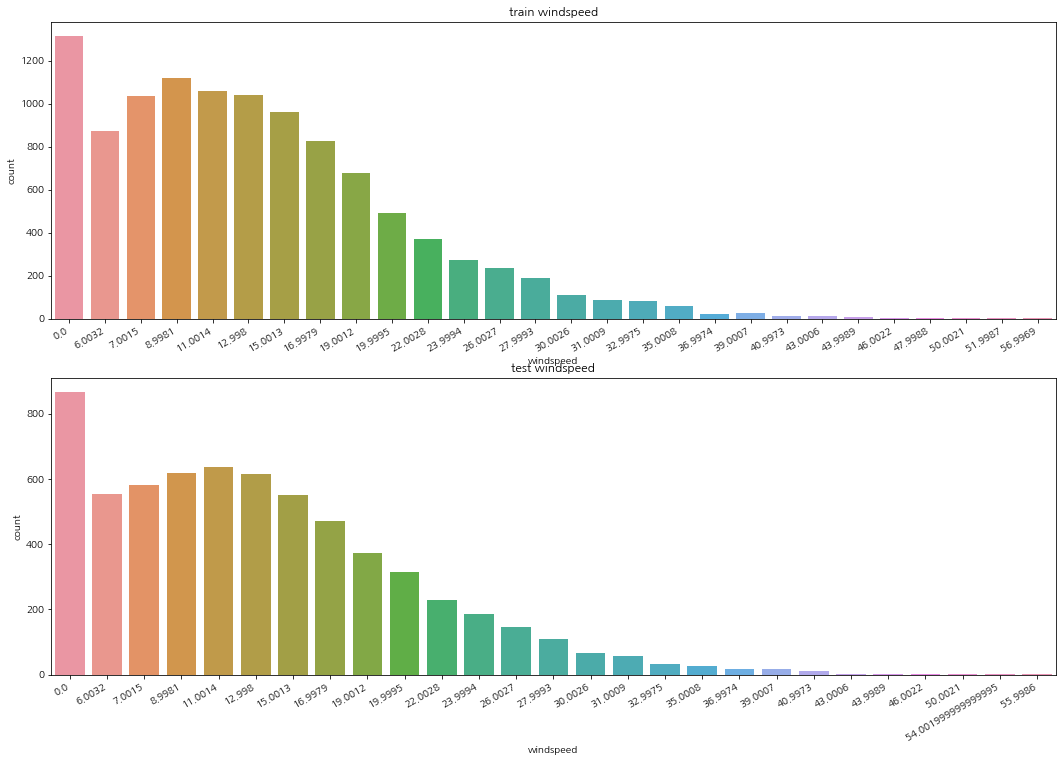

In [6]:
# windspeed 풍속에 0 값이 가장 많음 -> 잘못 기록된 데이터 고칠 필요가 있음.
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,12)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel="Count", title="train windspeed")
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel="Count", title="test windspeed")
sns.countplot(data=test, x='windspeed', ax=axes[1])

plt.show()

- train 데이터 뿐만 아니라 test 데이터에도 windspeed값이 0인 데이터가 많은 것을 확인할 수 있다.   
- 측정되지 않은 데이터들을 0으로 입력했을 것이라고 예측하고 보정하기로 함.
- 0인 값을 평균으로 대치하는 것은 예측의 정확도를 높이는 데 도움이 될 것 같진 않음.

In [8]:
# 풍속이 0인것과 아닌 것 나누기
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [9]:
# 머신러닝으로 예측을 통해 풍속 값을 채우기로 함.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    # 0인 값과 아닌 것 나누기
    dataWind0 = data.loc[data['windspeed']==0]
    dataWindNot0 = data.loc[data['windspeed']!=0]
    
    # 풍속 예측할 피처 선택
    wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']
    
    # 풍속이 0이 아닌 데이터들 타입 string으로 변경
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
    
    # 랜덤포레스트 분류기 사용
    rfModel_wind = RandomForestClassifier()
    
    # wCol에 있는 피처 값 바탕으로 모델 학습
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    
    # 학습한 값 바탕으로 풍속이 0으로 기록된 데이터 풍속 예측
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])
    
    # 비교를 위해 예측 값 넣을 데이터 프레임 생성
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    # 0인 풍속값에 예측값 대입
    predictWind0['windspeed'] = wind0Values
    
    # 0이 아닌 풍속값 데이터와 예측값 데이터프레임 합치기
    data = predictWindNot0.append(predictWind0)
    
    # 풍속 데이터타입 float로 지정
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

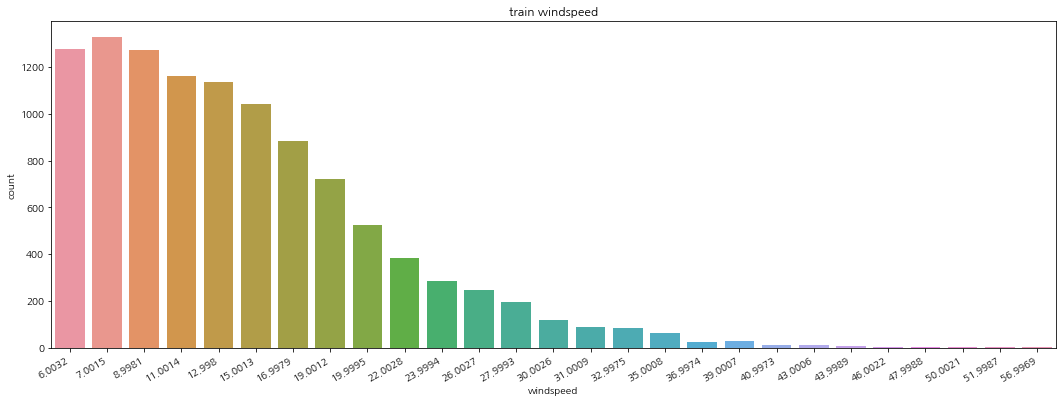

In [10]:
# 0값 조정
train = predict_windspeed(train)

# windspeed의 0값 조정한 데이터 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel = 'Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

값이 0이었던 데이터들이 예측값으로 대체된 것을 확인할 수 있다.

### Feature Selection
- 신호와 잡음을 구분해야 한다.
- 피처가 많다고해서 무조건 좋은 성능을 내지는 않는다.
- 피처를 하나씩 추가하고 변경해가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [11]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek'],
      dtype='object')

In [13]:
# 연속형 feature와 범주형 feature
# 연속형 feature = ['temp', 'humidity', 'windspeed', 'atemp']
# 범주형 feature의 type을 category로 변경해준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [16]:
# feature 선택
feature_names =  ['season', 'holiday', 'workingday', 'weather', 'temp',
                   'atemp', 'humidity', 'windspeed', 'year', 'hour', 'dayofweek']
feature_names

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek']

In [18]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek
0,1,0,0,2,9.84,12.880,75,6.0032,2011,5,5
1,1,0,0,1,15.58,19.695,76,16.9979,2011,10,5
2,1,0,0,1,14.76,16.665,81,19.0012,2011,11,5
3,1,0,0,1,17.22,21.210,77,19.0012,2011,12,5
4,1,0,0,2,18.86,22.725,72,19.9995,2011,13,5


In [20]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,2011,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,4,3


In [21]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

### Score

### RMSLE
과대평가된 항목보다는 과소평가된 항목에 패널티를 준다.   
오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root)으로 값이 작을 수록 정밀도가 높다.   
0에 가까운 값이 나올 수록 정밀도가 높은 값이다.   

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

- $n$ is the number of hours in the test set
- $p_i$ is your predicted count
- $a_i$ is the actual count
- $log(x)$ is the natural logarithm
- 잔차(residual)에 대한 평균에 로그를 씌운 값이다.(과대평가된 항목보다 과소평가된 항목에 패널티 주기 위해)
- 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클수록 오차가 크다는 의미이다.
- 값이 작을수록 오류가 적다는 의미를 나타낸다.

In [22]:
# RMSLE 계산
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값 빼주고 제곱 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균 내기
    mean_difference = difference.mean()
    
    # 루트 씌우기
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

### Cross Validation 교차 검증
- 일반화 성능을 측정하기 위해 데이터를 여러번 반복해서 나누고 여러 모델 학습한다. 

**KFold 교차검증**

- 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.   
- 첫번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습한다.   
- 나머지 훈련세트로 만들어진 세트의 정확도를 첫번째 폴드로 평가한다.   
- 다음은 두번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련세트를 두번째 폴드의 정확도로 측정한다.   
- 이 과정을 마지막 폴드까지 반복한다.   
- 이렇게 훈련세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸게 정확도가 된다.   


In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

### RandomForest
- n_estimator값이 높을수록 좋은 성능을 냄. but 시간이 오래 걸림

In [24]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators= 100,
                             n_jobs= -1,
                             random_state=0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [25]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0애 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

Wall time: 26.7 s
Score= 0.33157


### Train

In [26]:
# 모델 학습 - 피처와 레이블 넣어주면 알아서 학습함.
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [27]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.45,   4.99,   4.24,   3.51,   3.13,   6.42,  38.3 , 105.29,
       236.72, 134.71])

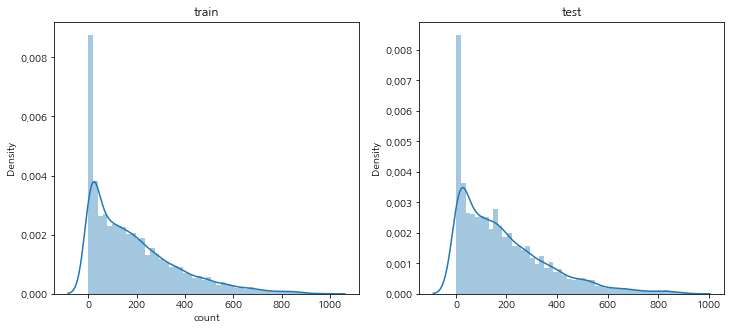

In [29]:
# 예측한 데이터 시각화
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')
sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')
plt.show()

- train 데이터와 예측한 count값 모두 0에 많은 값에 몰려있다.
- 두 그래프를 비교해보았을 때 동일하진 않지만 어느정도 비슷하게 예측한 것을 확인할 수 있다.

### Submit

In [30]:
submission = pd.read_csv("./bike-sharing-demand/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.45
1,2011-01-20 01:00:00,4.99
2,2011-01-20 02:00:00,4.24
3,2011-01-20 03:00:00,3.51
4,2011-01-20 04:00:00,3.13


In [31]:
submission.to_csv("./bike-sharing-demand/Score_{0:.5f}_submission.csv".format(score), index=False)

참고:
- [오늘코드 자전거 수요 예측 |Youtube](https://www.youtube.com/watch?v=g7EwIFXJntc&t=530)
- [EDA & Ensemble Model (Top 10 Percentile) | Kaggle](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)
- [How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? (part -1)](https://medium.com/analytics-vidhya/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-1-c816ea9c51e1)
- [How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? (part -2)](https://medium.com/analytics-vidhya/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-1-c816ea9c51e1)